Check the BC fluxes, namely to get a sense of whether velocities
are being included as expected.

Run `short_22` has exactly one boundary with forcing, `ji=10`, which
is on the northern side of the grid, N-S exchange, on a ragged corner,
not far from the NW corner of the grid.

The unorm values match with the expected forcing on this edge.

The next question is whether the observed lack of match before was from
having multiple velocities defined on a single cell, or some other cause.

In [56]:
%matplotlib inline

In [1]:
import logging
log=logging.getLogger('ocean_dfm')
log.setLevel(logging.INFO)

import subprocess
import copy
import os
import sys
import glob
import shutil
import datetime

import six

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from stompy.spatial import proj_utils, field

from stompy.model.delft import dfm_grid
from stompy.model import otps

from stompy import filters, utils
from stompy.spatial import wkb2shp

import stompy.model.delft.io as dio
from stompy.grid import unstructured_grid

import sfb_dfm_utils

In [2]:
## 
dfm_bin_dir="/opt/software/delft/dfm/r53925-opt/bin"

utm2ll=proj_utils.mapper('EPSG:26910','WGS84')
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

mdu=dio.MDUFile('template.mdu')

# short_test_01: straight up waterlevel, 100% from OTPS
# short_test_02: fix bathy, tried riemann, dirichlet
# short_test_03: add DC offset, start comparing Point Reyes
#                clip bathy to -4, not -10
#                add salinity to BC and mdu.  initial=34
#                bump up to 6 days
# short_test_04: Adding COAMPS wind
# short_test_05: Convert to more complete DFM script
# short_test_06: Try 3D, 10 layers
# short_test_07: ragged boundary
# short_test_08: Adding SF Bay
# medium_09: Longer run, with temperature, and ill-behaved velocity
# medium_10: add sponge layer diffusion for scalars, too
# short_test_11: return to ROMS-only domain, and shorter duration
# short_test_12: attempt z layers
# short_test_13: bring the full domain back
# short_test_14: bring back depth-average advected velocity, and then depth-varying velocity
# medium_15: longer test.  runs, but doesn't look good against observations.
# medium_16: try forcing more velocity than freesurface.
# short_17: return to ocean only, single cores
# short_18: more aggressive sponge layer, no wind.
# short_19: add wind back in
# short_20: and switch to HYCOM
# short_21: now OTPS velocities, no freesurface BCsn
run_name="short_22"

include_fresh=False # or True
layers='z' # or 'sigma'
grid='ragged_coast' # 'rectangle_coast' 'ragged_full', ...
nprocs=1 # 16
mdu['physics','Temperature']=1
mdu['physics','Salinity']=1
use_wind=True

coastal_source=['otps','hycom'] # 'roms'

# ROMS has some wacky data, especially at depth.  set this to True to zero out
# data below a certain depth (written as positive-down sounding)
coastal_max_sounding=20000 # allow all depths
set_3d_ic=True
extrap_bay=False # for 3D initial condition whether to extrapolated data inside the Bay.

In [3]:
run_base_dir=os.path.join('runs',run_name)
os.path.exists(run_base_dir) or os.makedirs(run_base_dir)

mdu.set_filename(os.path.join(run_base_dir,run_name+".mdu"))

mdu['geometry','Kmx']=20
if layers=='sigma':
    mdu['geometry','SigmaGrowthFactor']=1

run_start=ref_date=np.datetime64('2017-07-01')
run_stop=np.datetime64('2017-07-15')

mdu.set_time_range(start=run_start,
                   stop=run_stop,
                   ref_date=ref_date)

if layers=='z':
    mdu['geometry','Layertype']=2 # z layers
    if 0: # works, but uniform layers
        mdu['geometry','StretchType']=0 # uniform
        mdu['geometry','StretchCoef']=""
    else:
        mdu['geometry','StretchType']=2 # exponential
        # surface percentage, ignored, bottom percentage
        # mdu['geometry','StretchCoef']="0.002 0.02 0.8"
        # This gives about 2m surface cells, and O(500m) deep layers.
        mdu['geometry','StretchCoef']="0.0003 0.02 0.7"
        mdu['numerics','Zwsbtol'] = 0.0 # that's the default anyway...
        # This is the safer of the options, but gives a stairstepped bed.
        mdu['numerics','Keepzlayeringatbed']=1
        # This helps with reconstructing the z-layer geometry, better than
        # trying to duplicate dflowfm layer code.
        mdu['output','FullGridOutput']    = 1
elif layers=='sigma':
    mdu['geometry','Layertype']=1 # sigma
    if 1: # 
        mdu['geometry','StretchType']=1 # user defined 
        # These must sum exactly to 100.
        mdu['geometry','StretchCoef']="8 8 7 7 6 6 6 6 5 5 5 5 5 5 5 5 2 2 1 1"
    else:
        mdu['geometry','StretchType']=0 # uniform
else:
    raise Exception("bad layer choice '%s'"%layers)
    

old_bc_fn = os.path.join(run_base_dir,mdu['external forcing','ExtForceFile'])

from sfb_dfm_utils import ca_roms, coamps, hycom

# Get the ROMS inputs:
coastal_pad=np.timedelta64(10,'D') # lots of padding to avoid ringing from butterworth
coastal_time_range=[run_start-coastal_pad,run_stop+coastal_pad]
if 'roms' in coastal_source:
    coastal_files=ca_roms.fetch_ca_roms(coastal_time_range[0],coastal_time_range[1])
elif 'hycom' in coastal_source:
    # As long as these are big enough, don't change (okay if too large),
    # since the cached data relies on the ll ranges matching up.
    hycom_lon_range=[-124.7, -121.7 ]
    hycom_lat_range=[36.2, 38.85]

    coastal_files=hycom.fetch_range(hycom_lon_range,hycom_lat_range,coastal_time_range)
else:
    coastal_files=None

##
if grid=='rectangle_coast': # rectangular subset
    ugrid_file='derived/matched_grid_v00.nc'

    if not os.path.exists(ugrid_file):
        g=ca_roms.extract_roms_subgrid()
        ca_roms.add_coastal_bathy(g)
        g.write_ugrid(ugrid_file)
    else:
        g=unstructured_grid.UnstructuredGrid.from_ugrid(ugrid_file)
    coastal_bc_coords=None 
    # should get some coordinates if I return to this grid
    raise Exception("Probably ought to fill in coastal_bc_coords for this grid")
elif grid=='ragged_coast': # ragged edge
    ugrid_file='derived/matched_grid_v01.nc'
    
    if not os.path.exists(ugrid_file):
        poly=wkb2shp.shp2geom('grid-poly-v00.shp')[0]['geom']
        g=ca_roms.extract_roms_subgrid_poly(poly)
        ca_roms.add_coastal_bathy(g)
        g.write_ugrid(ugrid_file)
    else:
        g=unstructured_grid.UnstructuredGrid.from_ugrid(ugrid_file)
        g_shp='derived/matched_grid_v01.shp'
        if not os.path.exists(g_shp):
            g.write_edges_shp(g_shp)
    coastal_bc_coords=[ [450980., 4291405.], # northern
                        [595426., 4037083.] ] # southern
elif grid=='ragged_splice': # Spliced grid generated in splice_grids.py
    ugrid_file='spliced_grids_01_bathy.nc'
    g=unstructured_grid.UnstructuredGrid.from_ugrid(ugrid_file)
    # define candidates based on start/end coordinates
    coastal_bc_coords=[ [450980., 4291405.], # northern
                        [595426., 4037083.] ] # southern
else:
    raise Exception("Unknown grid %s"%grid)
## 

# Identify ocean boundary edges
# Limit the boundary edges to edges which have a real cell on the other
# side in the ROMS output

if coastal_files is not None:
    # Used to choose the candidate subset of edges based on some stuff in
    # the grid, but to be more flexible about choices of coastal ocean 
    # data, instead rely on a coordinate pair defining the section of
    # grid boundary to be forced by coastal sources

    if coastal_bc_coords is not None:
        candidate_nodes=g.select_nodes_boundary_segment(coastal_bc_coords)
        candidates=[ g.nodes_to_edge( [a,b] )
                     for a,b in zip(candidate_nodes[:-1],
                                    candidate_nodes[1:]) ]
        candidates=np.array(candidates)
    else:
        candidates=None # !? danger will robinson.
        
    ca_roms.annotate_grid_from_data(g,coastal_files,candidate_edges=candidates)

    boundary_edges=np.nonzero( g.edges['src_idx_out'][:,0] >= 0 )[0]

## 

# To get lat/lon info, and later used for the initial condition
src=xr.open_dataset(coastal_files[0])

INFO:root:/opt/data/delft/cache/hycom/2017062100--124.70_-121.70_36.20_38.85.nc
INFO:root:Will assume wet-cells in first time step true for eternity
INFO:ca_roms:0/7676


In [4]:
# May move more of this to sfb_dfm_utils in the future
Otps=otps.otps_model.OTPS('/home/rusty/src/otps/OTPS2', # Locations of the OTPS software
                          '/opt/data/otps') # location of the data

# xy for boundary edges:
boundary_out_lats=src.lat.values[ g.edges['src_idx_out'][boundary_edges,0] ]
boundary_out_lons=(src.lon.values[ g.edges['src_idx_out'][boundary_edges,1] ] + 180) % 360 - 180
boundary_out_ll=np.c_[boundary_out_lons,boundary_out_lats]

z_harmonics = Otps.extract_HC( boundary_out_ll )
u_harmonics = Otps.extract_HC( boundary_out_ll, quant='u')
v_harmonics = Otps.extract_HC( boundary_out_ll, quant='v')
U_harmonics = Otps.extract_HC( boundary_out_ll, quant='u')
V_harmonics = Otps.extract_HC( boundary_out_ll, quant='v')

pad=np.timedelta64(2,'D')
otps_times=np.arange(run_start-pad, run_stop+pad,
                     np.timedelta64(600,'s'))
otps_water_level=otps.reconstruct(z_harmonics,otps_times)
otps_u=otps.reconstruct(u_harmonics,otps_times)
otps_v=otps.reconstruct(v_harmonics,otps_times)
otps_U=otps.reconstruct(U_harmonics,otps_times)
otps_V=otps.reconstruct(V_harmonics,otps_times)

# convert cm/s to m/s
otps_u.result[:] *= 0.01 
otps_v.result[:] *= 0.01

In [26]:
if 'edge_depth' in g.edges.dtype.names:
    edge_depth=g.edges['edge_depth']
else:
    edge_depth=g.nodes['depth'][ g.edges['nodes'] ].mean(axis=1)
                                                         

sign='regular'

map_ds22=xr.open_dataset('/hpcvol1/rusty/dfm/sfb_ocean/runs/short_22/DFM_OUTPUT_short_22/short_22_map.nc')
map_ds21=xr.open_dataset('/hpcvol1/rusty/dfm/sfb_ocean/runs/short_21/DFM_OUTPUT_short_21/short_21_map.nc')
map_time_i=180

In [9]:
map_ds=map_ds22 # shorter than map_ds21
otps_time_i=np.searchsorted( otps_times, map_ds.time.isel(time=map_time_i) )

time_err=otps_times[otps_time_i] - map_ds.time.isel(time=map_time_i)
print("Time mismatch between output and OTPS is %.3fh"%( time_err/np.timedelta64(3600,'s')))

boundary_fluxes=np.zeros(len(boundary_edges),'f8')

dfm_zeta_offset=1.0

for ji,j in enumerate(boundary_edges):
    if ji!=10:
        continue # to match short_22
    src_name='oce%05d'%j
    
    depth=edge_depth[j]

    if 1: # bring in OTPS harmonics:
        water_level=dfm_zeta_offset + otps_water_level.result.isel(site=ji)

        veloc_u=otps_u.result.isel(site=ji)
        veloc_v=otps_v.result.isel(site=ji)
        veloc_uv=xr.DataArray(np.c_[veloc_u.values,veloc_v.values],
                              coords=[('time',veloc_u.time),('comp',['e','n'])])
        veloc_uv.name='uv'

        # inward-positive
        # testing for reversed:
        veloc_normal=(g.edges['bc_norm_in'][j,0]*veloc_u + g.edges['bc_norm_in'][j,1]*veloc_v)
        if sign=='reverse':
            veloc_normal*=-1

        boundary_fluxes[ji]=veloc_normal.isel(time=otps_time_i)

Time mismatch between output and OTPS is 0.000h


In [10]:
unorms=map_ds.unorm.isel(time=map_time_i,laydim=-1) # nFlowLink
FlowLink_from=map_ds.FlowLink.values[:,0] - 1 # make 0-based
FlowLink_to  =map_ds.FlowLink.values[:,1] - 1 

elt_x = map_ds.FlowElem_xzw.values
elt_y = map_ds.FlowElem_yzw.values
elt_xy=np.c_[elt_x,elt_y]

# All 'to' indices are real elements.
# from indices include boundaries

from_xy=np.zeros( (len(FlowLink_from),2), 'f8')
to_xy  =np.zeros( (len(FlowLink_from),2), 'f8')
is_bc=FlowLink_from >= len(elt_xy)
from_xy[ ~is_bc ] = elt_xy[ FlowLink_from[~is_bc] ]

to_xy[ :,: ] = elt_xy[ FlowLink_to ]
from_xy[ is_bc ]= to_xy[is_bc] 

link_xy=0.5*(from_xy+to_xy)
link_xy[ is_bc ] += (np.random.random( (is_bc.sum(),2)) - 0.5)*1000

link_norms=utils.to_unit( to_xy - from_xy )
link_norms[ np.isnan(link_norms) ] = 0

/home/rusty/python/stompy/utils.py:517: RuntimeWarning: invalid value encountered in true_divide
  return vecs / mag(vecs)[...,None]


(432345.213924441, 463446.0182044875, 4263579.584740996, 4298346.406697517)

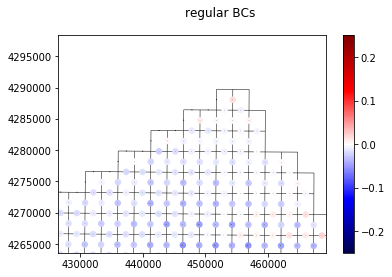

In [13]:
# Not a robust way to discern normals to go with boundary condition unorm values.
# can at least scatter plot them.

if sign=='reverse':
    num=1
else:
    num=2

plt.figure(num).clf()
fig,ax=plt.subplots(num=num)
fig.suptitle('%s BCs'%sign)

g.plot_edges(ax=ax,lw=0.5,color='k',zorder=-1)

boundary_edge_xy=g.edges_center()[boundary_edges]


ax.quiver( boundary_edge_xy[:,0],boundary_edge_xy[:,1],
           boundary_fluxes*g.edges['bc_norm_in'][boundary_edges,0],
           boundary_fluxes*g.edges['bc_norm_in'][boundary_edges,1])
scat=ax.scatter( link_xy[:,0],link_xy[:,1],30,unorms,cmap='seismic')
scat.set_clim([-0.25,0.25])

plt.colorbar(scat)


ax.quiver( link_xy[:,0],link_xy[:,1],
           unorms * link_norms[:,0], unorms*link_norms[:,1],
           color='g')

ax.axis( (432345.21392444102,
          463446.01820448751,
          4263579.5847409964,
          4298346.4066975173) )

In [ ]:
# At first glance the BC velocities are reverse to what is in the output.
# Hard to be sure without knowing normals

# Plotting unorms * normals for the FlowLinks we can (non-BC), 
# seems that positive unorm is north and east

# the majority of the bc edges seem consistent with positive=in, and
# matching up with imposed OTPS velocities, but not all.

# e.g. 
# an edge with an inward normal pointing south is at 
# This place looks like the forcing and the output are opposite.
if 0:
    southward=np.array( [421590.92978347285, 4270014.9450852871] )
    southward_element=np.array([421607.6316436067, 4268211.144190832])
else:
    southward=np.array( [447855.82588489528, 4286429.771834890])
    southward_element=np.array( [447812.06420383614, 4284723.066273585])


plt.figure(1).axes[0].text( southward[0],southward[1],'Southward')
plt.figure(1).axes[0].text( southward_element[0],southward_element[1],'Southward Elt')

# In the reversed case, it has OTPS velocities coming in,
# but the two blue dots show that dfm thinks flow is out.
# how do they look in time?

In [33]:
def calc_veloc_normal(ji):
    j=boundary_edges[ji]
    veloc_u=otps_u.result.isel(site=ji)
    veloc_v=otps_v.result.isel(site=ji)
    veloc_uv=xr.DataArray(np.c_[veloc_u.values,veloc_v.values],
                          coords=[('time',veloc_u.time),('comp',['e','n'])])
    veloc_uv.name='uv'

    # inward-positive
    veloc_normal=(g.edges['bc_norm_in'][j,0]*veloc_u + g.edges['bc_norm_in'][j,1]*veloc_v)
    if sign=='reverse':
        veloc_normal*=-1
    return veloc_normal



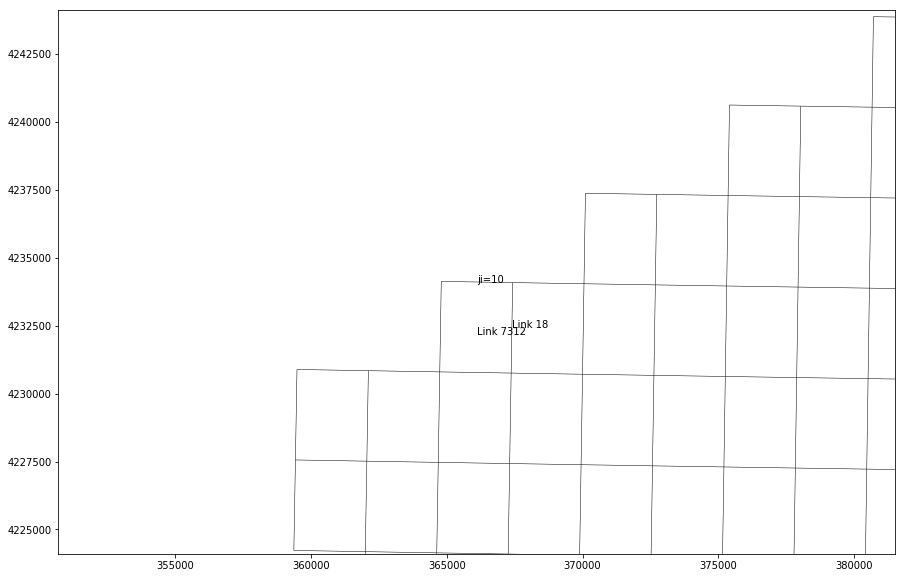

In [18]:
# in short_22, ji==10 is the only bc link
ji=10 # np.argmin( utils.dist(boundary_edge_xy - southward ) )
j=boundary_edges[ji]

fig,ax=plt.subplots(figsize=(15,10))

g.plot_edges(ax=ax,lw=0.5,color='k',zorder=-1)

boundary_edge_xy=g.edges_center()[boundary_edges]

ax.text( boundary_edge_xy[ji,0],
         boundary_edge_xy[ji,1],
         'ji=%d'%ji)

x0,y0=boundary_edge_xy[ji,:]
zoom=[x0-10e3,x0+10e3,y0-10e3,y0+10e3]
ax.axis(zoom)

# What link is this?
# if chosen based on coordinate:
# link_i = np.argsort( utils.dist( link_xy - southward_element) )[:2]
link_i = np.argsort( utils.dist( link_xy - boundary_edge_xy[ji]))[:2]
for li in link_i:
    ax.text( link_xy[li,0],
             link_xy[li,1],
             'Link %d'%li)
    
# based on the plot, then it's clear which is the boundary link,
# since it plots in the middle of the cell.
link=7312

(736510.0, 736514.0, -0.045015783905726796, 0.060885882009639618)

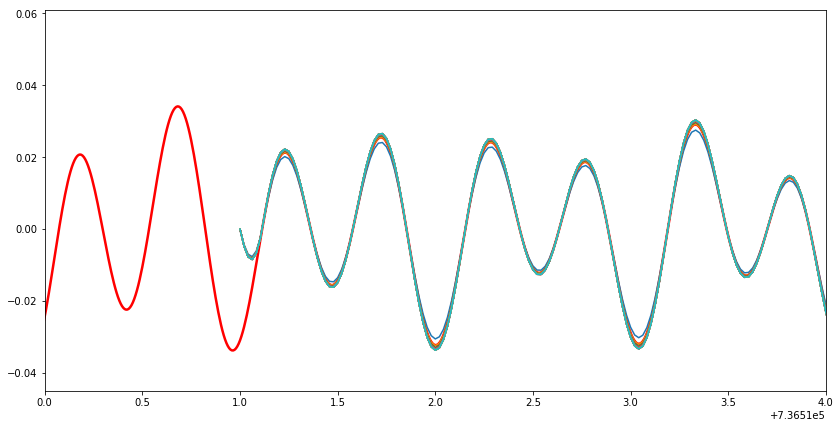

In [25]:
fig3,ax3=plt.subplots(figsize=(14,7))
# These applied velocities ...
ax3.plot( utils.to_dnum(otps_times), veloc_normal,'r-',zorder=-0.5,lw=2.5 )

# are opposite these fluxes coming out
for li in [link]:
    ax3.plot( utils.to_dnum(map_ds22.time),
              map_ds22.unorm.isel(nFlowLink=li),'g-' )

ax3.axis( xmin=736510., xmax=736514.)
# sure enough, at this point, these unorm values are opposite
# Is that true for other places?
# Here, they don't look like the same data, though.
# where 'here' is from the second set of coordinates up there.
# when trying this again, but with a run that had exactly one boundary
# forced, not reversing signs, the agreement is very good.

In [87]:
# Difficult to do this graphically, and hard to match the links up
# 1:1.  However, it would be enough to just get the right flux into
# each cell, and that should be unambiguous.

# select the file to test:
if 0:
    map_ds=map_ds22
    def test_boundary(ji):
        return ji==10
if 1:
    map_ds=map_ds21
    def test_boundary(ji):
        return True

In [88]:
unorms=map_ds.unorm.isel(time=map_time_i,laydim=-1) # nFlowLink
FlowLink_from=map_ds.FlowLink.values[:,0] - 1 # make 0-based
FlowLink_to  =map_ds.FlowLink.values[:,1] - 1 

elt_xy = np.c_[ map_ds.FlowElem_xzw.values, map_ds.FlowElem_yzw.values]

# All 'to' indices are real elements.
# from indices include boundaries

to_xy = elt_xy[ FlowLink_to ]
from_xy=to_xy.copy()
is_bc=FlowLink_from >= len(elt_xy)
from_xy[ ~is_bc ] = elt_xy[ FlowLink_from[~is_bc] ]

link_xy=0.5*(from_xy+to_xy)
# add jitter for plotting dots not on top of each other
# link_xy[ is_bc ] += (np.random.random( (is_bc.sum(),2)) - 0.5)*1000

link_norms=np.zeros_like(to_xy)
link_norms[~is_bc] = utils.to_unit( (to_xy - from_xy)[~is_bc] )

In [89]:
e2c=g.edge_to_cells(recalc=True)


INFO:UnstructuredGrid:Recalculating edge to cells


Internal element: 4
  link 7318 is BC  3753(-7)=>4
  match element 4 to grid cell 4 with dist 9.3314e-10
  Which participates in boundary edges j=14
  of which the active are j=14
  including OTPS flow for ji=6  j=14


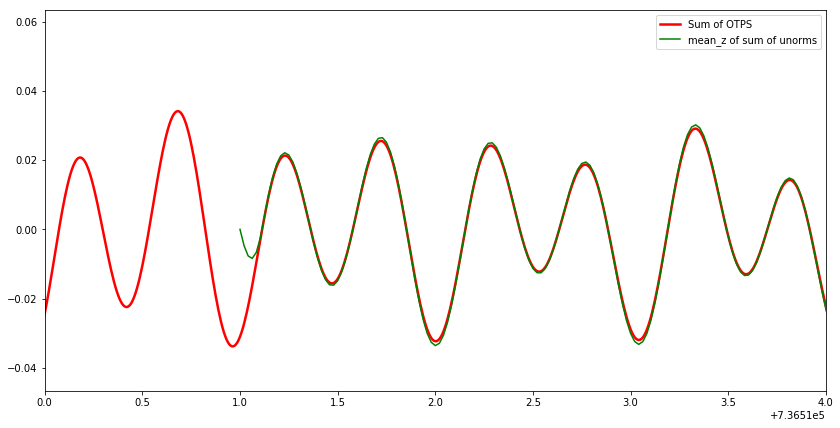

In [95]:
# 1. Find all cells which have BC exchanges, based on map_ds
bc_elems=np.unique(FlowLink_to[is_bc])

# 2. Loop over those, and collect both bc links, and boundary_edges
#    involved with that cell.

# bc_elems[0]: scaling maybe by -2?
# bc_elems[1]: scaling by 1.3 ?

for bc_elem in bc_elems[3:]:
    print("Internal element:",bc_elem)
    
    match_bc_links=np.nonzero( (FlowLink_to==bc_elem)&is_bc )[0]
    # display basic info on those links
    influx_data=0
    for bc_link in match_bc_links:
        to_elt=FlowLink_to[bc_link]
        from_elt=FlowLink_from[bc_link]
        print("  link %d is BC  %d(%d)=>%d"%(bc_link,from_elt,
                                           len(map_ds.nFlowElem)-1-from_elt,to_elt))
        #print("      internal cell ctr: %s"%(elt_xy[to_elt]))
        influx_data=influx_data + map_ds.unorm.isel(nFlowLink=bc_link)
        
    # now on the input side:
    # first, select the cell based on center, just to be sure

    cell_i = g.select_cells_nearest(elt_xy[bc_elem])
    cell_xy = g.cells_centroid([cell_i])[0]
    delta=utils.dist(cell_xy - elt_xy[to_elt])
    print("  match element %d to grid cell %d with dist %g"%(bc_elem,cell_i,delta))
    assert delta<1000.0 # so far <<1.0

    # go from that cell index to the boundary edges:
    bc_jis,sides=np.nonzero( e2c[boundary_edges] == cell_i )
    bc_js=boundary_edges[bc_jis]
    assert np.all(sides==0) # not really necessary, but weird if it fails

    print("  Which participates in boundary edges j=%s"%( ",".join(["%d"%j for j in bc_js])))
    
    active=np.array([test_boundary(ji) for ji in bc_jis])
    print("  of which the active are j=%s"%( ",".join(["%d"%j for j in bc_js[active]])))

    veloc_normal_sum=0.0
    for ji in bc_jis[active]:
        print("  including OTPS flow for ji=%d  j=%d"%(ji,boundary_edges[ji]))
        veloc_normal=calc_veloc_normal(ji)
        veloc_normal_sum = veloc_normal_sum + veloc_normal
        
    influx_mean=influx_data.mean(dim='laydim')

    # and
    
    if 1: # plot one..
        fig3,ax3=plt.subplots(figsize=(14,7))
        ax3.plot( utils.to_dnum(veloc_normal_sum.time), veloc_normal_sum,'r-',zorder=-0.5,lw=2.5,
                  label="Sum of OTPS")

        #ax3.plot( utils.to_dnum(influx_data.time),influx_data.values,'g-' )
        ax3.plot( utils.to_dnum(influx_data.time),influx_mean.values,'g-',
                  label="mean_z of sum of unorms")

        ax3.axis( xmin=736510., xmax=736514.)
        ax3.legend()
        break

In [83]:
influx_data

<xarray.DataArray 'unorm' (time: 190, laydim: 20)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [-0.004297, -0.004556, -0.004631, ..., -0.004739, -0.004739, -0.004739],
       [-0.007005, -0.007427, -0.007549, ..., -0.007726, -0.007726, -0.007726],
       ..., 
       [ 0.009376,  0.00994 ,  0.010104, ...,  0.010341,  0.010341,  0.010341],
       [ 0.006499,  0.006891,  0.007004, ...,  0.007168,  0.007168,  0.007168],
       [ 0.002551,  0.002704,  0.002749, ...,  0.002813,  0.002813,  0.002813]])
Coordinates:
    FlowLink_xu  float64 ...
    FlowLink_yu  float64 ...
  * time         (time) datetime64[ns] 2017-07-01 2017-07-01T00:30:00 ...
Dimensions without coordinates: laydim

(736510.0, 736514.0, -0.045015783905726796, 0.060885882009639618)

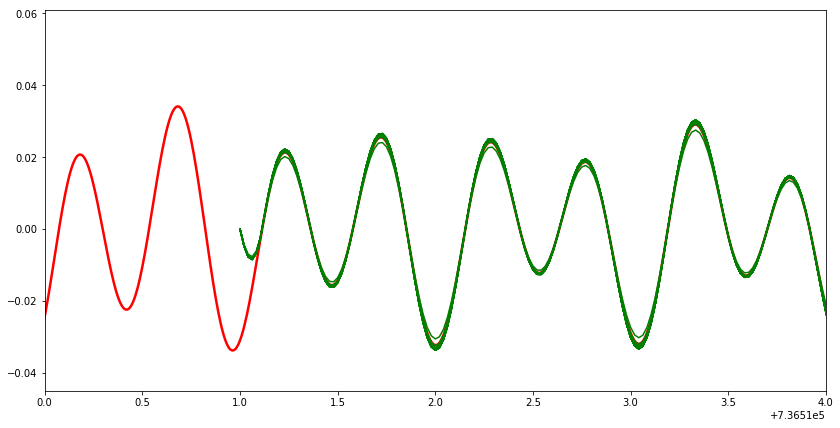